In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [33]:

import torch

print("是否检测到 GPU：", torch.cuda.is_available())
print("当前设备：", torch.cuda.get_device_name(1) if torch.cuda.is_available() else "无 GPU")
print("PyTorch 编译的 CUDA 版本：", torch.version.cuda)


是否检测到 GPU： True
当前设备： NVIDIA A800-SXM4-40GB
PyTorch 编译的 CUDA 版本： 12.1


In [34]:
dataset= r'dataset_with_diverse_descriptors.csv'
data=pd.DataFrame(pd.read_csv(dataset))


In [35]:
X = data.values[:, :-1]
y = data.values[:, -1]
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=1)


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [37]:
# 3. 建立 TabNet 分类器
from pytorch_tabnet.tab_model import TabNetClassifier


# 2. 定义模型
clf = TabNetClassifier(n_d=64,
    n_a=64,
    n_steps=3,
    gamma=1.3,
    lambda_sparse=1e-3,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax',
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=10,
    seed=42
)
from sklearn.utils.class_weight import compute_sample_weight

# 计算每个样本的权重（平衡类别）
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# 训练 TabNet 时传入 sample_weight
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=5000,
    patience=200,
    batch_size=32,
    virtual_batch_size=32,
    num_workers=3,
    drop_last=False,
    weights=sample_weights  # ✅ 传入权重
)

/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01441 | valid_accuracy: 0.67785 |  0:00:01s
epoch 10 | loss: 0.4704  | valid_accuracy: 0.80537 |  0:00:23s
epoch 20 | loss: 0.40813 | valid_accuracy: 0.79195 |  0:00:44s
epoch 30 | loss: 0.40427 | valid_accuracy: 0.80537 |  0:01:04s
epoch 40 | loss: 0.38193 | valid_accuracy: 0.82886 |  0:01:25s
epoch 50 | loss: 0.33675 | valid_accuracy: 0.83221 |  0:01:45s
epoch 60 | loss: 0.32182 | valid_accuracy: 0.83221 |  0:02:06s
epoch 70 | loss: 0.29489 | valid_accuracy: 0.82886 |  0:02:26s
epoch 80 | loss: 0.26979 | valid_accuracy: 0.84564 |  0:02:47s
epoch 90 | loss: 0.2933  | valid_accuracy: 0.82886 |  0:03:07s
epoch 100| loss: 0.2775  | valid_accuracy: 0.84899 |  0:03:28s
epoch 110| loss: 0.2547  | valid_accuracy: 0.8557  |  0:03:49s
epoch 120| loss: 0.22615 | valid_accuracy: 0.85235 |  0:04:09s
epoch 130| loss: 0.24378 | valid_accuracy: 0.85235 |  0:04:30s
epoch 140| loss: 0.24772 | valid_accuracy: 0.85906 |  0:04:50s
epoch 150| loss: 0.18938 | valid_accuracy: 0.84899 |  0

/opt/conda/lib/python3.11/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [38]:
# 5. 保存模型
clf.save_model("result/tabnet_model")

Successfully saved model at result/tabnet_model.zip


'result/tabnet_model.zip'

In [39]:
# 6. 评估
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8825503355704698
              precision    recall  f1-score   support

         1.0       0.83      0.89      0.86       118
         2.0       0.92      0.88      0.90       180

    accuracy                           0.88       298
   macro avg       0.88      0.88      0.88       298
weighted avg       0.89      0.88      0.88       298



# 评估

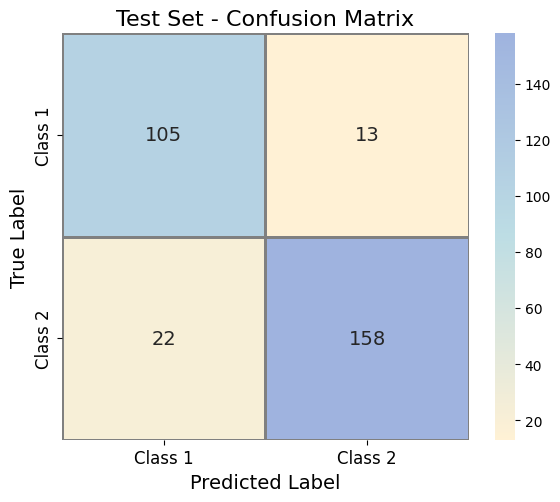

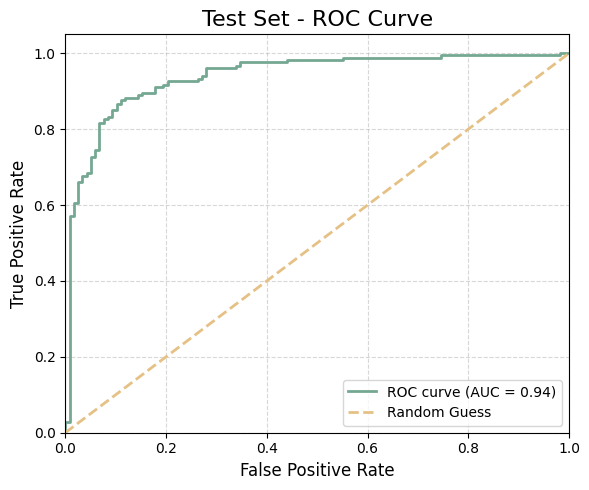

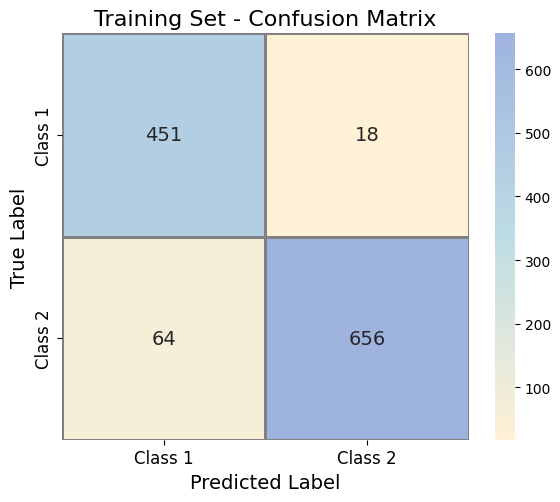

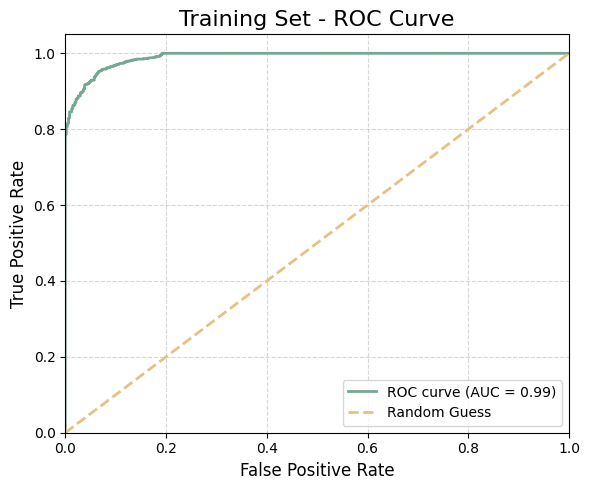

=== 测试集评估结果 ===
准确率: 0.8826
AUC: 0.9400

分类报告:
              precision    recall  f1-score   support

     Class 1       0.83      0.89      0.86       118
     Class 2       0.92      0.88      0.90       180

    accuracy                           0.88       298
   macro avg       0.88      0.88      0.88       298
weighted avg       0.89      0.88      0.88       298


=== 训练集评估结果 ===
准确率: 0.9310
AUC: 0.9899

分类报告:
              precision    recall  f1-score   support

     Class 1       0.88      0.96      0.92       469
     Class 2       0.97      0.91      0.94       720

    accuracy                           0.93      1189
   macro avg       0.92      0.94      0.93      1189
weighted avg       0.93      0.93      0.93      1189



In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np

# ====================
# 测试集评估
# ====================

# 1. 混淆矩阵 - 测试集
y_pred_test = clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)

# 自定义颜色映射
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [  '#FFF1D5','#BDDDE4','#9FB3DF']
)

# 绘制混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap=custom_cmap,
    cbar=True,
    square=True,
    linewidths=1,
    linecolor='gray',
    annot_kws={"size": 14},
    xticklabels=['Class 1', 'Class 2'],  # ✅ 添加标签
    yticklabels=['Class 1', 'Class 2']   # ✅ 添加标签
)
plt.title("Test Set - Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("result/test-confusion_matrix_with_cbar.png", dpi=300, bbox_inches='tight')
plt.show()

# 2. ROC曲线 - 测试集 (修正版)
# ✅ 获取预测概率而不是预测标签
y_prob_test = clf.predict_proba(X_test)[:, 1]  # 获取类别2的概率

# ✅ 将标签转换为0和1 (1->0, 2->1)
y_test_binary = (y_test == 2).astype(int)

fpr, tpr, thresholds = roc_curve(y_test_binary, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="#74a892", lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color="#e5c185", lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Test Set - ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("result/test-roc_curve_custom.png", dpi=300, bbox_inches='tight')
plt.show()

# ====================
# 训练集评估
# ====================

# 3. 混淆矩阵 - 训练集
y_pred_train = clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_train,
    annot=True,
    fmt='d',
    cmap=custom_cmap,
    cbar=True,
    square=True,
    linewidths=1,
    linecolor='gray',
    annot_kws={"size": 14},
    xticklabels=['Class 1', 'Class 2'],  # ✅ 添加标签
    yticklabels=['Class 1', 'Class 2']   # ✅ 添加标签
)
plt.title("Training Set - Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("result/train-confusion_matrix_with_cbar.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. ROC曲线 - 训练集 (修正版)
# ✅ 获取预测概率
y_prob_train = clf.predict_proba(X_train)[:, 1]  # 获取类别2的概率

# ✅ 将标签转换为0和1
y_train_binary = (y_train == 2).astype(int)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train_binary, y_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, color="#74a892", lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], color="#e5c185", lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Training Set - ROC Curve", fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("result/train-roc_curve_custom.png", dpi=300, bbox_inches='tight')
plt.show()

# ====================
# 额外的评估指标
# ====================

from sklearn.metrics import classification_report, accuracy_score

print("=== 测试集评估结果 ===")
print(f"准确率: {accuracy_score(y_test, y_pred_test):.4f}")
print(f"AUC: {roc_auc:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred_test, target_names=['Class 1', 'Class 2']))

print("\n=== 训练集评估结果 ===")
print(f"准确率: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"AUC: {roc_auc_train:.4f}")
print("\n分类报告:")
print(classification_report(y_train, y_pred_train, target_names=['Class 1', 'Class 2']))

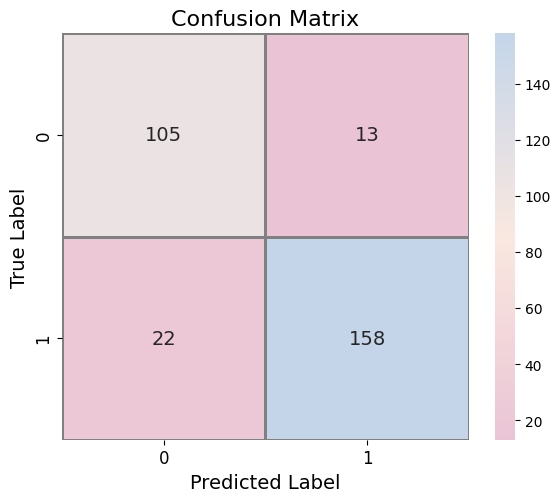

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# 1. 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 2. 自定义渐变颜色条，从 #e5c185 到 #74a892
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', ['#eac4d5','#fae8e0','#c4d5ea']
)

# 3. 绘图
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap=custom_cmap,
    cbar=True,              # 开启颜色条
    square=True,
    linewidths=1,
    linecolor='gray',
    annot_kws={"size": 14}
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("result/test-confusion_matrix_with_cbar.png", dpi=300)
plt.show()


In [41]:
from sklearn.metrics import roc_curve, auc

# y_prob 是正类的预测概率，例如 model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="#74a892", lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color="#e5c185", lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("result/test-roc_curve_custom.png", dpi=300)
plt.show()


ValueError: y_true takes value in {1.0, 2.0} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

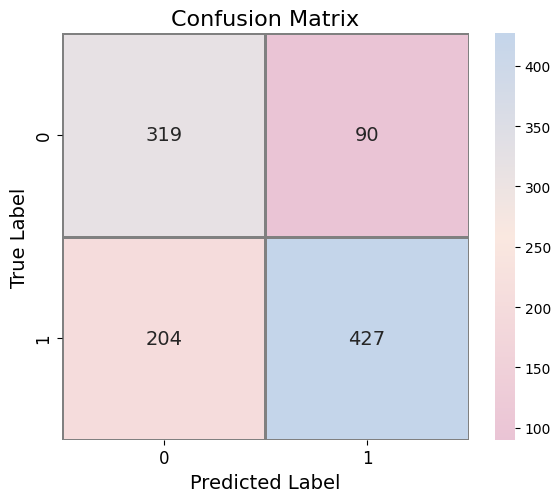

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_train = clf.predict(X_train)
# 1. 计算混淆矩阵
cm = confusion_matrix(y_train, y_pred_train)

# 2. 自定义渐变颜色条，从 #e5c185 到 #74a892
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', ['#eac4d5','#fae8e0','#c4d5ea']
)

# 3. 绘图
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap=custom_cmap,
    cbar=True,              # 开启颜色条
    square=True,
    linewidths=1,
    linecolor='gray',
    annot_kws={"size": 14}
)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("result/train-confusion_matrix_with_cbar.png", dpi=300)
plt.show()


In [23]:
from sklearn.metrics import roc_curve, auc

# y_prob 是正类的预测概率，例如 model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="#74a892", lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color="#e5c185", lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("result/train-roc_curve_custom.png", dpi=300)
plt.show()


ValueError: y_true takes value in {1.0, 2.0} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.